# Smartphone Sensordata Data Prep and Model Training

In [126]:
!pip install ibm-cos-sdk 
!pip install ibm-watson-machine-learning --upgrade
!pip install --upgrade sklearn
!pip install psycopg2-binary

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Requirement already up-to-date: ibm-watson-machine-learning in /opt/conda/envs/Python-3.7-main/lib/p

In [127]:
import os
from datetime import datetime, timedelta
import psycopg2

import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import pytz
import time
from datetime import datetime
from dateutil import parser
import scipy.io as sio

import ibm_boto3
from botocore.client import Config

from ibm_watson_machine_learning import APIClient

#### set Watson Machine Learning API Key and Endpoint 

In [128]:
### put your wml credentials (url and apikey) in here and the Deployment SpaceID where you want to put it

In [129]:
# The code was removed by Watson Studio for sharing.

#### load the file sensor_data

In [130]:
### go to the right, to files and put in "sensor_data_prepared.pkl" - Insert to code - Credentials in this cell

In [131]:
# The code was removed by Watson Studio for sharing.

In [132]:
cos = ibm_boto3.client('s3',
                   ibm_api_key_id=credentials_objectstorage['IBM_API_KEY_ID'],
                   ibm_service_instance_id=credentials_objectstorage['IAM_SERVICE_ID'],
                   ibm_auth_endpoint=credentials_objectstorage['IBM_AUTH_ENDPOINT'],
                   config=Config(signature_version='oauth'),
                   endpoint_url=credentials_objectstorage['ENDPOINT'])


In [133]:
def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_objectstorage['BUCKET'], Key=filename)['Body']
    return fileobject

In [134]:
with open(credentials_objectstorage['FILE'], 'wb') as data:
    cos.download_fileobj(credentials_objectstorage['BUCKET'], 'sensor_data_prepared.pkl', data)

In [135]:
!ls

mein_baum.dot  sensor_data_prepared.pkl  tree.png


In [136]:
df_prepared = pd.read_pickle("sensor_data_prepared.pkl")

In [137]:
df_prepared.head()

,values,labels,time_window_start
0,"[0.14917819, 0.104440264, -9.754576, 0.1536673...",lying,2021-04-09 08:13:36.639
1,"[0.15621117, 0.092768535, -9.749189, 0.1550140...",lying,2021-04-09 08:13:37.139
2,"[0.1547148, 0.09621018, -9.747543, 0.1563608, ...",lying,2021-04-09 08:13:37.640
3,"[0.15815647, 0.10294388, -9.772383, 0.15920393...",lying,2021-04-09 08:13:38.139
4,"[0.15561262, 0.09995113, -9.757718, 0.16234632...",lying,2021-04-09 08:13:38.639


In [138]:
train_X_agg = df_prepared["values"].tolist()
train_y_agg = df_prepared["labels"].tolist()
time_window = df_prepared["time_window_start"].tolist()

In [139]:
set(train_y_agg)

{'lying', 'stairs', 'walking'}

# Splitting data into training data set and a test data set

In [140]:
X_train, X_test, y_train, y_test = train_test_split(train_X_agg, train_y_agg, test_size=0.1, random_state=42)

In [141]:
len(train_X_agg)

5450

In [142]:
len(X_train)

4905

# Train a model the most simple way

In [143]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [144]:
clf.predict(X_test[0:5])

array(['stairs', 'walking', 'walking', 'stairs', 'lying'], dtype='<U7')

In [145]:
clf.score(X_test, y_test)

0.9614678899082569

In [146]:
clf.get_params(dict)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [147]:
clf.estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=769062348)

In [148]:
X_train[1]

array([0.1, 0.3, 9.6, 0.1, 0.3, 9.6, 0.1, 0.3, 9.6, 0.1, 0.3, 9.6, 0.1,
       0.3, 9.6, 0.1, 0.3, 9.6, 0.1, 0.3, 9.6, 0.1, 0.3, 9.6, 0.1, 0.3,
       9.6, 0.1, 0.3, 9.6])

In [150]:
from sklearn.tree import export_graphviz

column_names = []
sensor_labels = ["x", "y", "z"]
iterations = int(len(X_train[0])/(len(sensor_labels)))
for i in range(0,iterations, 1):
    sensor_labels_temp = [ current_label + "_" + str(i+1) for current_label in sensor_labels]
    column_names.append(sensor_labels_temp)
column_names = np.concatenate(column_names, axis=None)

In [151]:
len(column_names)

30

In [152]:
column_names

array(['x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3',
       'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5', 'x_6', 'y_6', 'z_6',
       'x_7', 'y_7', 'z_7', 'x_8', 'y_8', 'z_8', 'x_9', 'y_9', 'z_9',
       'x_10', 'y_10', 'z_10'], dtype='<U4')

In [153]:
export_graphviz(clf.estimators_[0],
                feature_names=column_names,
                out_file="mein_baum.dot",
                filled=True,
                rounded=True)

In [154]:
! dot -Tpng mein_baum.dot -o tree.png

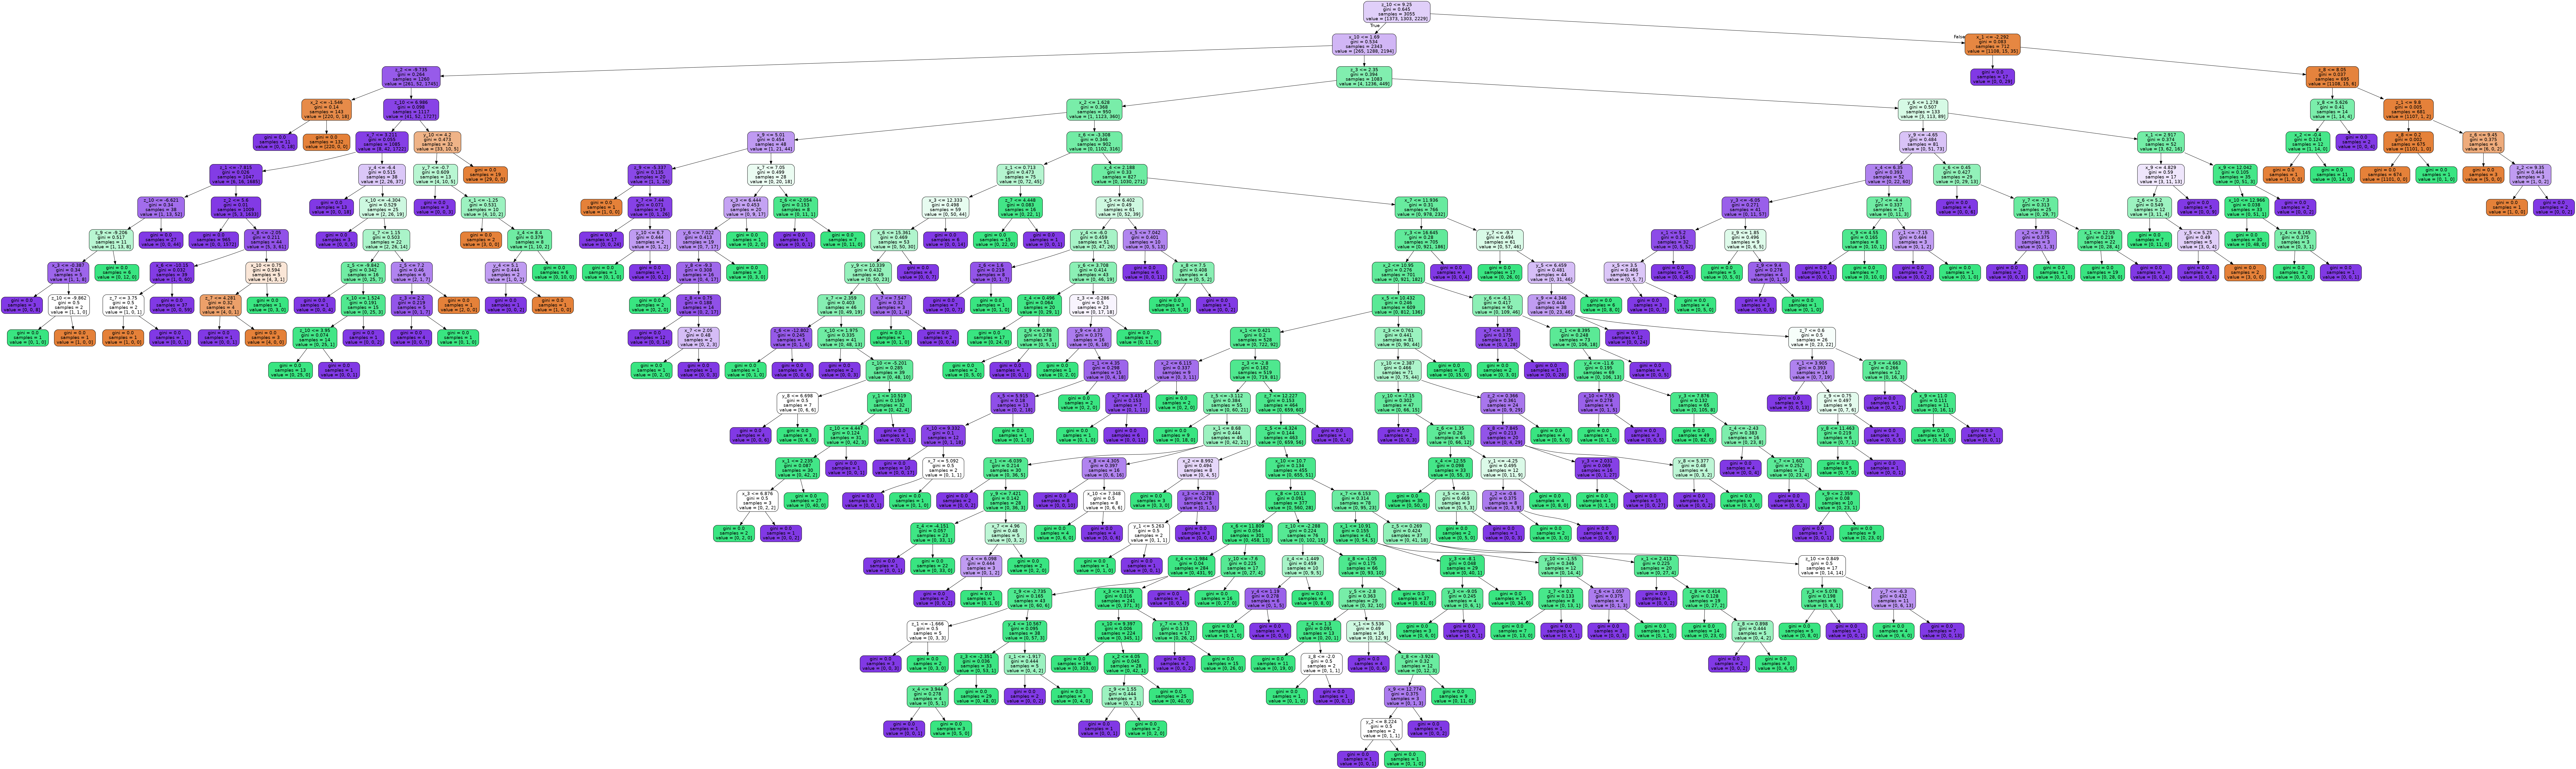

In [155]:
from IPython.display import Image
Image(filename='tree.png') 

## Do Training and Test with optimized Hyperparameters in one step

In [156]:
## train a model with random forest // multiclass
#hyperparameters = {"criterion": ["entropy", "gini"],
#                  "max_depth": [2,3,4,5,6,7,8,10,13,15],
#                   "max_features": ["log2", "sqrt"],
#                   "min_samples_leaf": [1,3, 5],
#                   "min_samples_split": [3, 5],
#                   "n_estimators": [6,9,30,60]
#}

## optimized params to save time when just quickly redeploying 
hyperparameters = {"criterion": ["gini"],
                   "max_depth": [13],
                   "max_features": ["sqrt"],
                   "min_samples_leaf": [1],
                   "min_samples_split": [5],
                   "n_estimators": [60]
}

## for really fast testing...
#hyperparameters = {"criterion": ["entropy", "gini"]}

clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid=hyperparameters, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)
                   
best_params = grid.best_params_
best_score = grid.best_score_
best_model_RandomForest = grid.best_estimator_

best_score
results = grid.cv_results_

In [157]:
grid.scorer_

make_scorer(accuracy_score)

In [158]:
results["mean_test_score"]

array([0.93781662])

In [159]:
results

{'mean_fit_time': array([0.6624644]),
 'std_fit_time': array([0.01515137]),
 'mean_score_time': array([0.00906577]),
 'std_score_time': array([0.00015015]),
 'param_criterion': masked_array(data=['gini'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[13],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[60],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini',
   'max_depth': 13,
   'max_features':

In [160]:
best_params

{'criterion': 'gini',
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 60}

In [161]:
best_model_RandomForest.predict(X_test[0:5])

array(['stairs', 'walking', 'walking', 'stairs', 'lying'], dtype='<U7')

In [162]:
y_test[0:5]

['stairs', 'walking', 'walking', 'stairs', 'lying']

In [163]:
best_model_RandomForest.score(X_test[0:5], y_test[0:5])

1.0

In [164]:
best_model_RandomForest.predict_proba(X_test[0:2])

array([[0.        , 0.86213135, 0.13786865],
       [0.        , 0.        , 1.        ]])

## push the model to Watson Machine Learning

In [165]:
## connect to WML
client_wml = APIClient(wml_credentials)
client_wml.set.default_space(space_uid)

client_wml.repository.list_models()

------------------------------------  -------------------------------------------------------  ------------------------  -----------------
ID                                    NAME                                                     CREATED                   TYPE
b1390454-e1a3-479d-a454-e935fda51933  Smartphone Classification at 2021-04-16 09:40:49.010113  2021-04-16T09:40:55.002Z  scikit-learn_0.23
3eaf0fa9-4c1a-4af8-a50d-059392872517  SensorDataModel - P1 TreeBasedClassifierEstimator        2021-04-15T09:17:25.002Z  wml-hybrid_0.1
0cb4cc00-1598-4eab-b751-34fbc5fd9d3f  Smartphone Classification at 2021-03-29 10:09:27.710334  2021-03-29T10:09:29.002Z  scikit-learn_0.23
f37da7f3-c5d3-4c6e-8470-730a9fadd988  Smartphone Classification 06_19                          2021-03-02T20:26:04.002Z  scikit-learn_0.23
------------------------------------  -------------------------------------------------------  ------------------------  -----------------


In [166]:
client_wml.deployments.list()

------------------------------------  --------------------------------------  -----  ------------------------
GUID                                  NAME                                    STATE  CREATED
fa153c9b-10b6-46f8-a4da-2d1e1c495f44  TechcafeTest_onlyaccelerometer30values  ready  2021-04-15T09:19:09.844Z
6383e394-3a42-400a-9e4a-3f22eee53a94  SensorModel                             ready  2021-03-29T10:09:36.540Z
------------------------------------  --------------------------------------  -----  ------------------------


In [167]:
client_wml.spaces.list(limit=10)

------------------------------------  -----------------------------------------------------------  ------------------------
ID                                    NAME                                                         CREATED
e77be3d7-45ce-41f4-8a0e-43e316877505  openscale-express-path-c5841ac5-f131-412b-bd34-1deaf2465ba9  2021-03-29T10:20:01.169Z
c8069bcc-85e9-4e92-a382-f529b6ab8118  iot-smartphone-project                                       2021-03-02T19:51:50.177Z
b66e4872-2fe9-4c37-ac3f-58aaf06ead92  Game-of-Thrones-Deployment                                   2020-11-06T09:41:38.599Z
------------------------------------  -----------------------------------------------------------  ------------------------


In [168]:
##deployment_uids = client_wml.deployments.get_uids()
## model name / title for the model to deploy

model_name = "Smartphone Classification at " + str(datetime.today())

In [169]:
model_name

'Smartphone Classification at 2021-04-16 09:49:20.269915'

In [170]:
#publish
software_spec_uid = client_wml.software_specifications.get_uid_by_name("default_py3.7")
print('start publishing')
print("....")
model_props = {client_wml.repository.ModelMetaNames.DESCRIPTION: "IBM Max Dargatz",
               client_wml.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
               client_wml.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
               client_wml.repository.ModelMetaNames.NAME: model_name}
published_model = client_wml.repository.store_model(model=best_model_RandomForest, meta_props=model_props, \
                                            training_data=X_train, training_target=y_train)
print("done - published model")

start publishing
....
done - published model


In [171]:
client_wml.repository.list_models()

------------------------------------  -------------------------------------------------------  ------------------------  -----------------
ID                                    NAME                                                     CREATED                   TYPE
8fabc2df-7203-45d2-9953-ee185b08044f  Smartphone Classification at 2021-04-16 09:49:20.269915  2021-04-16T09:49:23.002Z  scikit-learn_0.23
b1390454-e1a3-479d-a454-e935fda51933  Smartphone Classification at 2021-04-16 09:40:49.010113  2021-04-16T09:40:55.002Z  scikit-learn_0.23
3eaf0fa9-4c1a-4af8-a50d-059392872517  SensorDataModel - P1 TreeBasedClassifierEstimator        2021-04-15T09:17:25.002Z  wml-hybrid_0.1
0cb4cc00-1598-4eab-b751-34fbc5fd9d3f  Smartphone Classification at 2021-03-29 10:09:27.710334  2021-03-29T10:09:29.002Z  scikit-learn_0.23
f37da7f3-c5d3-4c6e-8470-730a9fadd988  Smartphone Classification 06_19                          2021-03-02T20:26:04.002Z  scikit-learn_0.23
------------------------------------  -----

In [172]:
#load published model for testing
print('load model for testing')
published_model_uid = client_wml.repository.get_model_uid(published_model)
model_details = client_wml.repository.get_details(published_model_uid)
loaded_model = client_wml.repository.load(published_model_uid)

load model for testing


In [173]:
## test if it works
test_predictions = loaded_model.predict(X_test[0:5])
print(test_predictions)

['stairs' 'walking' 'walking' 'stairs' 'lying']


In [174]:
meta_props = {
    client_wml.deployments.ConfigurationMetaNames.NAME: "SensorModel",
    client_wml.deployments.ConfigurationMetaNames.ONLINE: {},
    }

In [175]:
#deploy
print('deploy')
created_deployment = client_wml.deployments.create(published_model_uid, meta_props=meta_props)

deploy
{"trace":"d21b41245f1bce591befec7e4fb4fa11","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}


--------------------------
Deployment creation failed
--------------------------




WMLClientError: Deployment creation failed. Error: 402. {"trace":"d21b41245f1bce591befec7e4fb4fa11","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}

In [ ]:
scoring_endpoint = client_wml.deployments.get_scoring_href(created_deployment)
deployments = client_wml.deployments.get_details()

In [ ]:
scoring_endpoint

In [ ]:
deployments

In [ ]:
X_test[0]

In [ ]:
values_payload = [l.tolist() for l in X_test]

In [ ]:
column_names = column_names.tolist()

In [ ]:
column_names

In [ ]:
import requests

# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
token_response = requests.post('https://iam.cloud.ibm.com/identity/token', data={"apikey": wml_credentials["apikey"], "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"fields": column_names, "values": values_payload[3:100]}]}

response_scoring = requests.post('https://us-south.ml.cloud.ibm.com/ml/v4/deployments/6383e394-3a42-400a-9e4a-3f22eee53a94/predictions?version=2021-03-29', json=payload_scoring, headers={'Authorization': 'Bearer ' + mltoken})
print("Scoring response")
print(response_scoring.json())